<a href="https://colab.research.google.com/github/sokhan1/PYTHON/blob/main/20240915.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#module

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive

# Data Load

In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Detect credit card anomalies/sample.ipynb'
data = pd.read_csv(file_path)
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,"{""nbformat"":4",nbformat_minor:0,"metadata:{""colab"":{""provenance"":[]",toc_visible:true,"authorship_tag:""ABX9TyN0FCzPKh8DGbHJq2FkaUc6""}","kernelspec:{""name"":""python3""","display_name:""Python 3""}","language_info:{""name"":""python""}}","cells:[{""cell_type"":""code""",execution_count:null,"metadata:{""id"":""o30YCSA64SxN""}",outputs:[],source:[]}]}


# EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Train, Test 분리

In [ ]:
# 1. X, y 분리
X= data.iloc[:, :-1]
Y= data.iloc[:, -1]
# print(X) # Time~Amount
# print(Y) # Class

# 2. train, test 분리
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

for train_index, test_index in kfold.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

print(X_train.shape, y_train.shape) #(227846, 30) (227846,) 80%
print(X_test.shape, y_test.shape) #(56961, 30) (56961,) 20%

(227846, 30) (227846,)
(56961, 30) (56961,)


# Train, Test 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


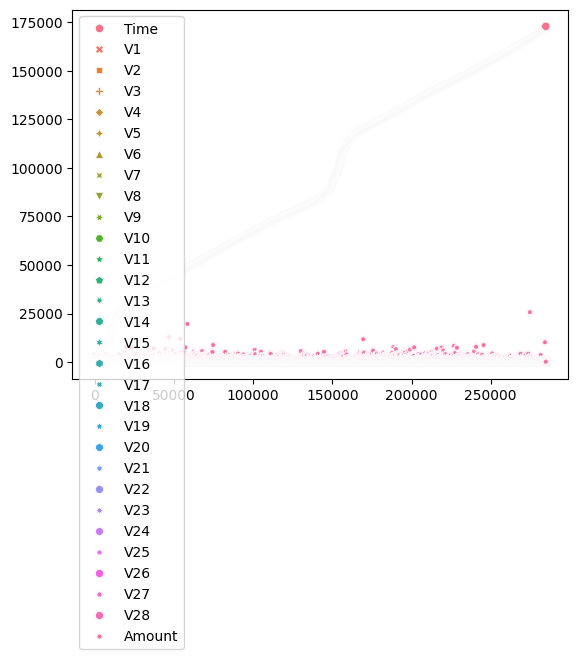

In [ ]:
import seaborn as sns
sns.scatterplot(X_train)
plt.show()

# Hyperparameter

## learning_rate_decay 변경
    linear -> cosine -> inverse


In [ ]:
# 1. 학습률
# 초기값 설정
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.95
epochs = np.arange(1, 101, dtype = 'float64')

# Exponential Decay
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate)
learning_rates_exp = [exponential_decay(epoch) for epoch in epochs]
print(learning_rates_exp)

# 2. 배치크기
batch_size = 2**17 #13만 #train 데이터의 약 50%크기

# 3. 반복횟수
#epoch = 5

# 4. 드롭아웃
drop_out=0.1 #숫자는 계속 수정해보면서 최적의 결과 도출해내기

[<tf.Tensor: shape=(), dtype=float32, numpy=0.009999487>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009998974>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009998461>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009997948>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009997436>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009996923>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099964095>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009995897>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009995384>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009994872>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00999436>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099938465>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009993333>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009992821>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009992309>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009991797>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099912835>, <tf.Tensor: shape=(), dtype=

# model 구축

## 가중치 초기화

In [ ]:
print(X_train.shape[1])

30


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential()

#가중치 초기화
weight_init = tf.keras.initializers.he_uniform()
# weight_init = tf.keras.initializaers.RandomNormal()
# weight_init = tf.keras.initializaers.glorot_uniform()

#model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_dim=30, kernel_initializer=weight_init))  # 첫 번째 은닉층
model.add(Dense(64, activation='relu'))  # 두 번째 은닉층
model.add(Dense(32, activation='relu'))  # 세 번째 은닉층
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

# 최적화

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=exponential_decay),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rates_exp),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

ValueError: Argument `learning_rate` should be float, or an instance of LearningRateSchedule, or a callable (that takes in the current iteration value and returns the corresponding learning rate value). Received instead: learning_rate=[<tf.Tensor: shape=(), dtype=float32, numpy=0.009999487>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009998974>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009998461>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009997948>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009997436>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009996923>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099964095>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009995897>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009995384>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009994872>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00999436>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099938465>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009993333>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009992821>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009992309>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009991797>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099912835>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009990771>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009990258>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009989747>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009989234>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009988721>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009988209>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009987697>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009987185>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009986673>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00998616>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009985648>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009985136>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009984624>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009984111>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009983599>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009983088>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009982575>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099820625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009981551>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00998104>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009980528>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009980015>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009979503>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009978992>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00997848>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009977968>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009977456>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009976945>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009976433>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00997592>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009975409>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009974898>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009974386>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009973874>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009973363>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009972851>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099723395>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009971828>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009971317>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009970806>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009970294>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009969783>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009969271>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099687595>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009968248>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009967737>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009967227>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009966714>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009966203>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009965693>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009965181>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00996467>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009964159>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009963647>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009963137>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009962626>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099621145>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009961603>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009961093>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099605825>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009960071>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00995956>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009959049>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009958538>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009958027>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009957517>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009957006>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009956496>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009955985>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009955474>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009954963>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099544525>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009953942>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009953432>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009952921>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009952411>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0099519>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009951389>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009950879>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009950369>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009949858>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009949348>, <tf.Tensor: shape=(), dtype=float32, numpy=0.009948838>]

# Training

In [ ]:
#생성된 데이터를 batch_size로 나누어, epoch만큼 학습시킴
history = model.fit(X_train, y_train, epochs=epoch, validation_data=(X_train, y_train), batch_size = batch_size)

Epoch 1/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7162 - loss: 5246.9219 - val_accuracy: 0.9983 - val_loss: 37.0226
Epoch 2/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9983 - loss: 47.7606 - val_accuracy: 0.9983 - val_loss: 101.7463
Epoch 3/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9983 - loss: 107.5150 - val_accuracy: 0.9983 - val_loss: 133.0889
Epoch 4/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9982 - loss: 136.8355 - val_accuracy: 0.9983 - val_loss: 144.7913
Epoch 5/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9983 - loss: 143.7049 - val_accuracy: 0.9983 - val_loss: 141.1693
Epoch 6/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9983 - loss: 137.3189 - val_accuracy: 0.9983 - val_loss: 119.6356


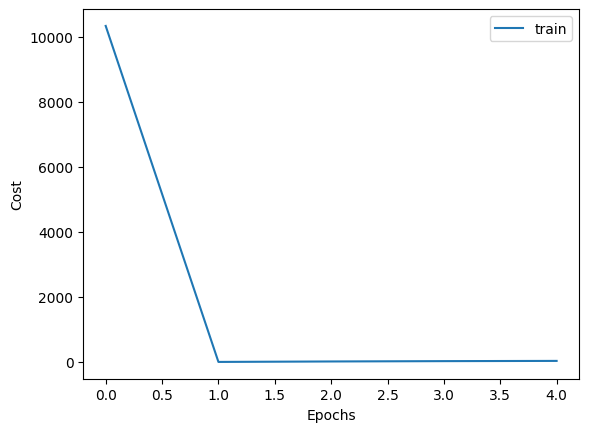

In [ ]:
plt.plot(history.history['loss'], label = "train")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("Test accuracy: ", test_acc)

# Test

In [ ]:
predictions = model.predict(X_test, y_test)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# accuracy 검증


In [ ]:
# confusion_matrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cnf_matrix = confusion_matrix(y_actual, y_pred, labels = ['cat', 'dog', 'rabbit'])
np.set_printoptions(precision = 2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['cat', 'dog', 'rabbit'], title = 'confusion matrix without normalization')
plt.show()

# 분류지표 계산
print(classification_report(y_train, y_train_pred))

# ROC(필요하면 쓰기)
from sklearn.metrics import roc_curve, auc
import pandas as pd

y_train_prob = lr.predict_proba(X_train)[:, 1]

fpr, tpr, threshold = roc_curve(y_train, y_train_prob)

a=pd.DataFrame()

a['fpr'] = 1-fpr
a['tpr'] = tpr
a['thres'] = threshold
# p(a)

import matplotlib.pyplot as plt

auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='auc: %.2f'%auc_score)
plt.show()

# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Visualization

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = "train") #그래프모양 변경가능
plt.xlabel("Epochs") # 변수수정
plt.ylabel("Cost") #변수수정
plt.legend()
plt.show()